In [1]:
""" Initialize the notebook """
import teca
import numpy as np
import xarray as xr
import pylab as PP
import cartopy.crs as ccrs

import TECAPyPlot

In [2]:
""" Define some control variables. """
# the variable on which to run the detection
detection_variable = 'IVT'
# the half-width-half-max width of the gaussian filter
hwhm_latitude = 30.0
# the threshold in IVT (post-filter)
absolute_value_threshold = 250.
# the center of the filter (latitude)
filter_center = 0.0

# set the files to read
data_regex = "MERRA_test/ARTMIP*"

In [3]:
""" Define the TECA reader"""

cfr = teca.teca_cf_reader.New()
cfr.set_files_regex(data_regex)
cfr.set_x_axis_variable('lon')
cfr.set_y_axis_variable('lat')
cfr.set_t_axis_variable('')

In [4]:
""" Construct the part of the algorithm that plots the raw input variable. """
plot_variable = TECAPyPlot.TECAPyPlot(detection_variable, title = "Raw input")

input_var_plot_alg = teca.teca_programmable_algorithm.New()
input_var_plot_alg.set_number_of_input_connections(1)
input_var_plot_alg.set_report_callback( plot_variable.get_report_callback())
input_var_plot_alg.set_request_callback(plot_variable.get_request_callback())
input_var_plot_alg.set_execute_callback(plot_variable.get_execute_callback())
input_var_plot_alg.set_input_connection(cfr.get_output_port())

In [5]:
""" Construct the latitude filter part of the algorithm. """

filter_alg = teca.teca_latitude_damper.New()
filter_alg.set_input_connection(input_var_plot_alg.get_output_port())
filter_alg.set_center(filter_center)
filter_alg.set_half_width_at_half_max(hwhm_latitude)
filter_alg.set_damped_variables([detection_variable])

In [6]:
""" Construct the part of the algorithm that plots the filtered variable. """
plot_variable = TECAPyPlot.TECAPyPlot(detection_variable, title = "After gaussian filter")

filter_plot_alg = teca.teca_programmable_algorithm.New()
filter_plot_alg.set_number_of_input_connections(1)
filter_plot_alg.set_report_callback( plot_variable.get_report_callback())
filter_plot_alg.set_request_callback(plot_variable.get_request_callback())
filter_plot_alg.set_execute_callback(plot_variable.get_execute_callback())
filter_plot_alg.set_input_connection(filter_alg.get_output_port())

In [7]:
""" Construct the segmentation part of the algorithm """

segmentation_alg = teca.teca_binary_segmentation.New()
segmentation_alg.set_input_connection(filter_plot_alg.get_output_port())
segmentation_alg.set_segmentation_variable(detection_variable)
segmentation_alg.set_threshold_variable(detection_variable)
segmentation_alg.set_low_threshold_value(absolute_value_threshold)

In [8]:
""" Construct the part of the algorithm that plots the segmentation mask. """
plot_variable = TECAPyPlot.TECAPyPlot(detection_variable, title = "After segmentation")

segmentation_plot_alg = teca.teca_programmable_algorithm.New()
segmentation_plot_alg.set_number_of_input_connections(1)
segmentation_plot_alg.set_report_callback( plot_variable.get_report_callback())
segmentation_plot_alg.set_request_callback(plot_variable.get_request_callback())
segmentation_plot_alg.set_execute_callback(plot_variable.get_execute_callback())
segmentation_plot_alg.set_input_connection(segmentation_alg.get_output_port())

In [9]:
""" Set the detector to only run on the first timestep. """
first_step = 0
last_step = 0
exe = teca.teca_time_step_executive.New()
exe.set_first_step(first_step)
exe.set_last_step(last_step)
segmentation_plot_alg.set_executive(exe)

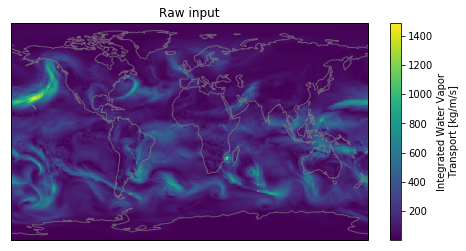

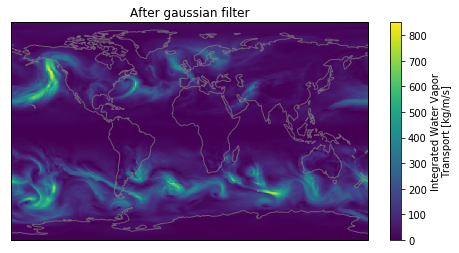

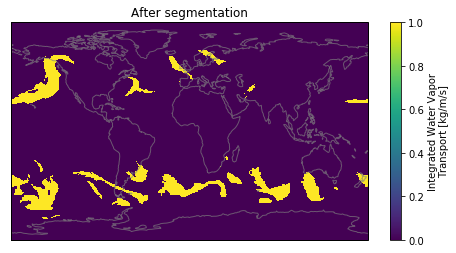

In [10]:
""" run the TECA AR pipeline """
retval = segmentation_plot_alg.update()